<a href="https://colab.research.google.com/github/DavidPachis/DeepLearning/blob/main/Taller1/noteBooks/Taller1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 1**

El lenguaje de señas ha sido una herramienta que por más de 300 años ha ayudado a millones de personas a comunicarse de una manera eficaz. Actualmente, el 5% de la población mundial sufre de pérdida auditiva y la OMS estima que en el 2050, 1 de cada 10 habitantes padecerá de alguna enfermedad relacionada a problemas auditivos.

Ante la nueva ola de máquinas relacionadas al campo de la medicina, un conjunto de médicos le ha pedido realizar un modelo que les permita interpretar de manera eficiente el lenguaje de señas a través de imágenes. Esto con el fin de poder atender a sus pacientes con limitaciones de comunicación y poderles brindar un mejor servicio. Para esto, los médicos le han proporcionado un conjunto de datos donde capturaron el "gesto" de cada una de las letras del abecedario y se encargaron de etiquetarlas, excluyendo las letras como la J y la Z debido a causa del movimiento.

Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:

1. Entrenamiento de un perceptrón multicapa.

2. Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.

3. Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

Datos: https://www.kaggle.com/datamunge/sign-language-mnist

# **Taller 1 – Análisis con Deep Learning**

Fabián Ramirez, David Vásquez

{fo.ramirez50, da.vasquez11} @uniandes.edu.co

Fecha de presentación: Septiembre 20 del 2022

## **Entrenamiento de un perceptrón multicapa.**

### Importación de paquetes

In [2]:
!pip install pandas
!pip install keras-tuner
!pip install wget
!pip install unzip
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 2.1 MB/s 
     |████████████████████████████████| 1.6 MB 17.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=97ed5d3d0a6df1d6442ee1b268bf64f2671d96469bfe9b1b91b8c9672e4b8d9f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1319 sha256=a17fe793313e03d8eaf87ad71aa0b52d39239a452158f850665855f0321fcb95
  Stored in directory: /root/.cache/pip/wheels/c5/05/b3/f7b36dbaaf76

Para este ejercicio, utilizaremos las siguientes librerías.

In [79]:
import pandas as pd
import numpy as np
import random
import wget
import zipfile
import keras as k
import keras_tuner as kt
import matplotlib as plt
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error, mean_absolute_error,classification_report, confusion_matrix

In [4]:
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

import tensorflow as tf
from scikeras.wrappers import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils.vis_utils import plot_model


###1. Entendimiento del negocio

El data set tiene 24 imagenes de lenguaje de señas de 28 x 28, donde se muestran las letras (sin J ni S)



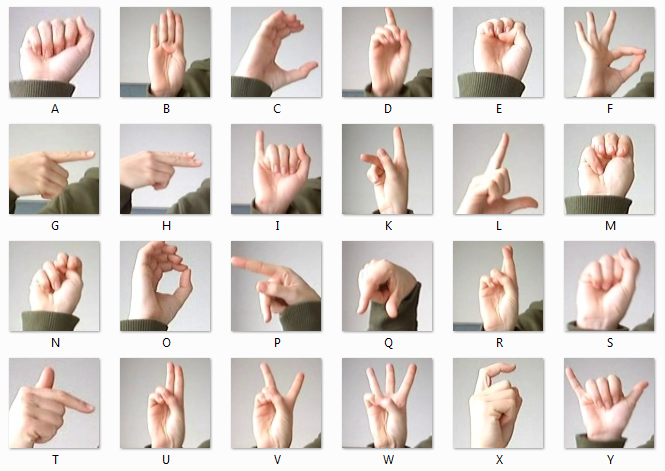

### Descarga de los Datos

In [5]:
descarga_test=wget.download('https://github.com/DavidPachis/DeepLearning/raw/main/Taller1/data/sign_mnist_test_csv.zip')
with zipfile.ZipFile('/content/sign_mnist_test_csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
    

In [6]:
descarga_train=wget.download('https://github.com/DavidPachis/DeepLearning/raw/main/Taller1/data/sign_mnist_train_csv.zip')
with zipfile.ZipFile('/content/sign_mnist_train_csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

### Exploración de los datos
 

El dataset consta de vectores de 784 registros, con un label correspondiente a la clasificación real de ese vector en las categorias de 0 a 24, excluyendo el 9. 

Estos números hacen referencia a las letras del abecedario, y el vector aplanado, es el resultado de "estirar" la matriz que contine los valores de los pixeles de la imagen de las señas.

Procedemos a hacer un diagrama de torta para ver qué tan balanceadas están las clases, este nos permite ver que cantidad de muestras hay por cada etiqueta en el dataset, Se hizo tambien para ver como estaba el data set de test, y se evidencio que el balance de clases de este, no es tan uniforme como el de entrenamiento, Aún así, las variaciones con respecto a los datos de entrenamiento no sobre pasan del 2-3% en cada clase. 
Un paso que no realizamos, pero pensamos en la revision de los datos, fue revisar los vectores. Pensamos en que si llegan vectores con etiquetados, en el que el vector realmente está mal, por ejemplo, que las columnas de una fila, sean todas de un mismo color, osea que tengan el mismo valor en todos los pixeles, o que varien muy poco. 
Esto no se realizó, y asumimos que los datos de entrenamiento estan correctamente etiquetados, pero es una variable a contemplar en un caso real.

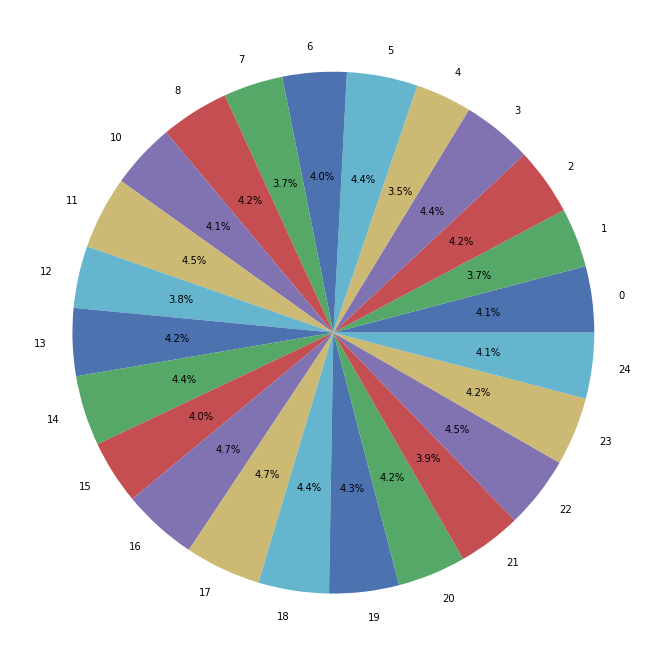

In [7]:
df_train = pd.read_csv('sign_mnist_train.csv')
df_train.groupby(['label']).size().plot(kind = 'pie', ylabel ='', autopct='%1.1f%%',figsize=(19,12))
df_test = pd.read_csv('sign_mnist_test.csv')


### Preparación de los datos


Debido a que los datos ya vienen segmentados en test y entrenamiento, no realizamos esa primera partición, y procedemos a hacer la división columnas objetivo y entrenamiento. 
El dataset esta conformado por arreglos de 784 pixeles, correpondientes a los valores de la imagen de de entrada. 

Procedemos a separar de los datos de train y test, la columna de etiquetado y a su vez crear los y de etiquetado. 

In [47]:
x_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']
x_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']

#display(x_train.head())
#y_train.head()

Visualizamos que datos quedan X_test, para revsisar el esquema esté correcto

In [48]:
x_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


Ahora realizamos la partición de mis datos de entrenamiento, para crear un grupo de datos de validación para analizar el comportamiento del modelo. 

In [49]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=33)

In [50]:
print(len(x_train))
print(len(x_test))

21964
7172


Procedemos a normalizar los datos, y trabajar con rangos de 0 a 1, esto o conseguimos dividiendo cada pixel por el valos máximo que puede tomar, que es 255.

In [51]:
x_train_n = x_train / 255
x_val_n = x_val / 255
x_test_n = x_test / 255

### Modelamiento


Vamos a utilizar la arquitectura de un Perceptron de mulicapa, la cual se ve de la siguiente manera:
Un entrada de 784 inputs, correspondiente 784 N, que hacen referencia a las columnas del dataset, que vienen a los 784 pixeles de las imagenes de señas.

Creamos una función para armar la arquitectura del modelo, en la cual podremos variar el numero de capas ocultas hasta 3, definir las funciones de activación de las capas ocultas, la función de perdida y la función del activación de las neuronas de salida.

Función de pérdida: "categorical_crossentropy"

Función de activación de N de capas ocultas: RELU

Función de activación de N de salida: Softmax, con  24 N, correspondientes a las clases de salida. 

En cuanto al número de épocas, luego de realizar varias pruebas decidimos dejarlo en numeros que no superaran los 20, pues siempre llegabamos a valores de accuracy de 1, encontrandonos sobreajustes en el modelo de X_val. por esta razón, decidimos dejarlas en este rango. 

In [62]:
def get_model(meta, activation, n_layers, hidden_layer_1, hidden_layer_2 = None, hidden_layer_3 = None):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    dims = [hidden_layer_1, hidden_layer_2, hidden_layer_3]

    model = Sequential(name="Red_MPC")
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:]))

    for i in range(n_layers):
        model.add(Dense(dims[i], activation=activation))    
    model.add(Dense(24, activation='softmax'))

    return model

In [63]:
clf = KerasClassifier(
    get_model,
    loss="categorical_crossentropy",
    n_layers=2,
    hidden_layer_1=256, 
    hidden_layer_2=100,
    hidden_layer_3=None,
    metrics=["accuracy"],
    epochs=10,
    activation="relu"
)

clf

KerasClassifier(
	model=<function get_model at 0x7f5268210680>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=categorical_crossentropy
	metrics=['accuracy']
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	n_layers=2
	hidden_layer_1=256
	hidden_layer_2=100
	hidden_layer_3=None
	activation=relu
	class_weight=None
)

In [64]:
estimators = [
              ('clf', clf),
              ]

pipe = Pipeline(estimators)

In [65]:
pipe.fit(x_train_n, y_train)

Epoch 1/10
687/687 [==============================] - 9s 12ms/step - loss: 2.7394 - accuracy: 0.1888
Epoch 2/10
687/687 [==============================] - 8s 12ms/step - loss: 1.5998 - accuracy: 0.4824
Epoch 3/10
687/687 [==============================] - 9s 12ms/step - loss: 1.0652 - accuracy: 0.6509
Epoch 4/10
687/687 [==============================] - 9s 12ms/step - loss: 0.8146 - accuracy: 0.7444
Epoch 5/10
687/687 [==============================] - 8s 12ms/step - loss: 0.6623 - accuracy: 0.8030
Epoch 6/10
687/687 [==============================] - 11s 16ms/step - loss: 0.5473 - accuracy: 0.8457
Epoch 7/10
687/687 [==============================] - 9s 13ms/step - loss: 0.5071 - accuracy: 0.8686
Epoch 8/10
687/687 [==============================] - 8s 12ms/step - loss: 0.4479 - accuracy: 0.8895
Epoch 9/10
687/687 [==============================] - 9s 12ms/step - loss: 0.4300 - accuracy: 0.9056
Epoch 10/10
687/687 [==============================] - 8s 12ms/step - loss: 0.4049 - accur

Pipeline(steps=[('clf',
                 KerasClassifier(activation='relu', epochs=10, hidden_layer_1=256, hidden_layer_2=100, hidden_layer_3=None, loss='categorical_crossentropy', metrics=['accuracy'], model=<function get_model at 0x7f5268210680>, n_layers=2))])

#### Evalucaion del modelo
Para mirar el rendimiento de nuestro modelo, vamos a utilizar nuestros datos de entrenamiento.

In [66]:
y_pred = pipe.predict(x_train_n)
y_pred

687/687 [==============================] - 4s 6ms/step


array([17,  0, 17, ..., 10, 19, 24])

In [67]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       899
           1       1.00      1.00      1.00       806
           2       1.00      1.00      1.00       915
           3       1.00      0.87      0.93       952
           4       1.00      1.00      1.00       767
           5       1.00      1.00      1.00       946
           6       0.99      0.99      0.99       868
           7       1.00      0.99      1.00       806
           8       0.99      1.00      1.00       926
          10       0.97      0.99      0.98       876
          11       1.00      0.99      0.99      1023
          12       1.00      0.99      0.99       861
          13       0.99      1.00      0.99       930
          14       1.00      1.00      1.00       964
          15       1.00      1.00      1.00       872
          16       1.00      0.99      0.99      1019
          17       0.93      0.96      0.95      1030
          18       1.00    

In [73]:
y_pred = pipe.predict(x_train)
y_pred
print(classification_report(y_train, y_pred))

687/687 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       899
           1       1.00      1.00      1.00       806
           2       1.00      1.00      1.00       915
           3       1.00      0.88      0.94       952
           4       1.00      1.00      1.00       767
           5       1.00      1.00      1.00       946
           6       1.00      0.99      0.99       868
           7       1.00      1.00      1.00       806
           8       1.00      0.99      0.99       926
          10       0.97      0.99      0.98       876
          11       1.00      0.98      0.99      1023
          12       1.00      0.99      0.99       861
          13       0.99      1.00      0.99       930
          14       1.00      1.00      1.00       964
          15       1.00      1.00      1.00       872
          16       1.00      0.99      1.00      1019
          17       0.91   

In [69]:
y_pred = pipe.predict(x_val_n)
y_pred
print(classification_report(y_val, y_pred))

172/172 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       1.00      1.00      1.00       204
           2       1.00      1.00      1.00       229
           3       1.00      0.89      0.94       244
           4       1.00      1.00      1.00       190
           5       0.99      1.00      0.99       258
           6       0.98      0.99      0.99       222
           7       1.00      0.98      0.99       207
           8       1.00      1.00      1.00       236
          10       0.99      0.99      0.99       238
          11       1.00      0.99      0.99       218
          12       1.00      0.99      0.99       194
          13       1.00      1.00      1.00       221
          14       1.00      1.00      1.00       232
          15       1.00      0.99      1.00       216
          16       1.00      0.99      0.99       260
          17       0.92   

#### Mejor Modelo, entonces hacemos de una vez el test 

In [70]:
y_pred = pipe.predict(x_test)

y_pred

225/225 [==============================] - 1s 4ms/step


array([ 6,  5, 10, ...,  2,  4,  2])

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       331
           1       1.00      0.98      0.99       432
           2       0.85      1.00      0.92       310
           3       0.90      0.53      0.66       245
           4       0.96      1.00      0.98       498
           5       0.94      0.88      0.91       247
           6       0.89      0.87      0.88       348
           7       0.97      0.91      0.93       436
           8       0.90      0.84      0.87       288
          10       0.79      0.66      0.72       331
          11       0.86      0.99      0.92       209
          12       0.85      0.67      0.75       394
          13       0.73      0.58      0.65       291
          14       1.00      0.79      0.88       246
          15       1.00      1.00      1.00       347
          16       0.87      0.86      0.86       164
          17       0.50      0.47      0.49       144
          18       0.72    

In [72]:
y_pred = pipe.predict(x_test_n)
y_pred
print(classification_report(y_test, y_pred))

225/225 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       331
           1       1.00      0.98      0.99       432
           2       0.86      1.00      0.92       310
           3       0.83      0.53      0.65       245
           4       0.95      1.00      0.97       498
           5       0.98      0.88      0.93       247
           6       0.89      0.88      0.88       348
           7       0.97      0.91      0.93       436
           8       0.90      0.85      0.88       288
          10       0.81      0.64      0.72       331
          11       0.86      1.00      0.92       209
          12       0.85      0.67      0.75       394
          13       0.68      0.58      0.63       291
          14       1.00      0.77      0.87       246
          15       1.00      1.00      1.00       347
          16       0.86      0.85      0.86       164
          17       0.59   

#### Análisis de los resultados

En el primera parte de evaluación, analisamos el modelo con las métricas de accuary, recall y presición, usando los datos de validacion que separamos al principio de algoritmo, y que corresponden al 20 % del total del dataset de entrada, un dataset que estaba bien blanceado, por lo cual la presición y el recall son buenas medidas por registrar, pues no van perder valides por el desbalanceo de las clases.

En este primer análisis con train encontramos un accuracy del 0.98, el cual nos lleva a la matriz de clasificación de las clases, que por ahora mostró un buen desempeño. Allí podemos ver que la mayoria de las clases obtuvieron buena clasificación, temimos un posible sobre ajuste, pero al momento de intentar con menos epocas y cambiar neuroras nos encontrabamos con modelos que tenian muy bajo desempeño, por ello dejamos este modelo. 

Luego procedimos a hacer una predición con los datos de entrenamiento, pero esta vez quisimos intentar hacerlo con el train set, pero sin normalizr, para ver como se comportaba el modelo. Los resultados fueron similares, se evidencia que las clases 20 en adelante y en esa zona tienen caracterisitcas similares, lo cual puede que tenga sentido, pues en estas señas tienen bastante similitud en sus forma. 

Una vez hechas estas validaciones, procedimos a hacer la prueba con el set de x_val, donde encontramos un comportamiento similar (Tambien probamos val normalizado y val sin normalizar)

Entonces a pesar de entender que tenemos un sobreajuste, decidimos probar el dataser de test, debido a que no logramos encontrar un termino medio en las mediciones de comportameinto del modelo. 

En el test, realizamos la misma dinámica de probar los datos normalizaods y sin normalizar, no encontramos diferencias entre estos dos resultados, pero el modelo es capas de reconocer las caracteristicas generales sin importar la escala. 
En el test de validación, nos encontramos con un desempeño menor, como esperabamos, debido al sobreajuste que tenemos del modelo, lo entedemos, pero nologramos encontrar un modelo mas óptimo para este punto. Este sobre ajuste puede ser basado en la escogencia de hiperparametros o epocas,pueden que se encuentre un modelo que tenga un mejor desempeño variando estos parametros. También, puede ser que necesitemos más muestras para lograr geralizar un modelo más robusto que sea capas de enfrentarse a un data set de test con muestras muy diferentes. 





### Prueba de modelo manual

Acá hicimos un modelo manual, sin pipelines y obtivumos resultados, parecidos, pero decidimos dejar el modelo anterior debido a la sencilles de creación, sumado a los problemas que tuvimos en cache y creacion de lso nuevos modelos por medio de las otras técnicas. 

In [32]:
model = Sequential(name="primer_MLP")
model.add(Input(shape=(x_train.shape[1]), name='Capa_Entrada'))
model.add(Dense(128,activation='relu',name='Capa_Oculta1'))
model.add(Dense(128,activation='relu',name='Capa_Oculta2'))
model.add(Dense(25,activation='softmax',name='Capa_Salida'))

In [33]:
model.summary()

Model: "primer_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Oculta1 (Dense)        (None, 128)               100480    
                                                                 
 Capa_Oculta2 (Dense)        (None, 128)               16512     
                                                                 
 Capa_Salida (Dense)         (None, 25)                3225      
                                                                 
Total params: 120,217
Trainable params: 120,217
Non-trainable params: 0
_________________________________________________________________


In [34]:
optimizer = tf.keras.optimizers.Adam(0.001)
#[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

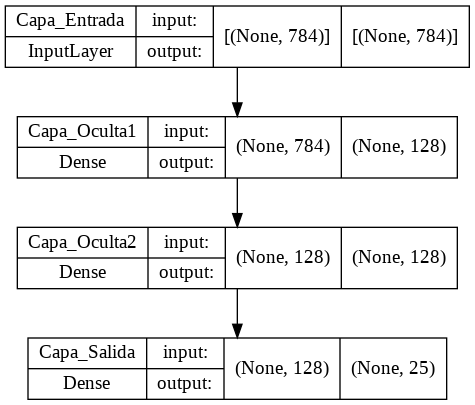

In [35]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [36]:
history = model.fit(x_train_n, y_train,batch_size=80,epochs=10)

Epoch 1/10
275/275 [==============================] - 1s 4ms/step - loss: 2.2567 - accuracy: 0.3254
Epoch 2/10
275/275 [==============================] - 1s 4ms/step - loss: 1.3359 - accuracy: 0.5860
Epoch 3/10
275/275 [==============================] - 1s 4ms/step - loss: 0.9918 - accuracy: 0.6909
Epoch 4/10
275/275 [==============================] - 1s 4ms/step - loss: 0.7537 - accuracy: 0.7693
Epoch 5/10
275/275 [==============================] - 1s 4ms/step - loss: 0.5897 - accuracy: 0.8179
Epoch 6/10
275/275 [==============================] - 1s 4ms/step - loss: 0.4674 - accuracy: 0.8581
Epoch 7/10
275/275 [==============================] - 1s 4ms/step - loss: 0.3654 - accuracy: 0.8935
Epoch 8/10
275/275 [==============================] - 1s 4ms/step - loss: 0.2997 - accuracy: 0.9135
Epoch 9/10
275/275 [==============================] - 1s 4ms/step - loss: 0.2227 - accuracy: 0.9420
Epoch 10/10
275/275 [==============================] - 1s 4ms/step - loss: 0.1886 - accuracy: 0.9524

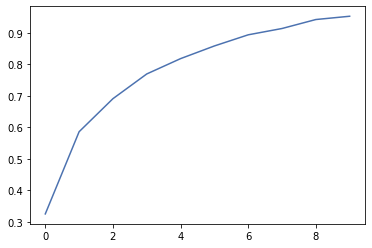

In [37]:
plt.plot(history.history['accuracy'])
plt.show()

In [38]:
y_pred = model.predict(x_train_n)
y_pred

array([[7.0292278e-28, 3.2925470e-06, 7.2273542e-16, ..., 8.7517338e-10,
        2.0570803e-07, 1.7633363e-12],
       [9.3023223e-01, 1.2181202e-05, 2.1879151e-08, ..., 8.2759275e-09,
        2.3148594e-09, 1.3104334e-06],
       [6.5432929e-13, 1.5493564e-03, 1.5053687e-10, ..., 1.6431866e-02,
        1.8941389e-05, 8.4095774e-04],
       ...,
       [8.7327781e-09, 5.5839465e-04, 1.2183465e-12, ..., 4.8433733e-04,
        2.7431519e-05, 8.1370827e-03],
       [2.8455122e-12, 1.0424760e-08, 3.3020857e-05, ..., 5.0202416e-06,
        3.2026149e-02, 5.8119949e-05],
       [2.6561995e-05, 1.7822525e-05, 1.6323472e-07, ..., 5.1251907e-05,
        1.4070682e-02, 3.7980860e-01]], dtype=float32)

In [39]:
y_pred=np.argmax(model.predict(x_train), axis=1)

In [40]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       899
           1       1.00      0.98      0.99       806
           2       1.00      1.00      1.00       915
           3       0.94      0.97      0.96       952
           4       0.98      0.98      0.98       767
           5       1.00      1.00      1.00       946
           6       1.00      0.98      0.99       868
           7       1.00      0.98      0.99       806
           8       0.94      0.98      0.96       926
          10       0.99      0.90      0.94       876
          11       1.00      0.98      0.99      1023
          12       1.00      0.89      0.94       861
          13       0.79      1.00      0.88       930
          14       1.00      0.98      0.99       964
          15       1.00      1.00      1.00       872
          16       1.00      0.99      0.99      1019
          17       0.76      0.98      0.86      1030
          18       1.00    

In [41]:
print(model.evaluate(x_val_n,  y_val, verbose=2))
y_pred=np.argmax(model.predict(x_val_n), axis=1)
print(classification_report(y_val, y_pred))

172/172 - 0s - loss: 0.1587 - accuracy: 0.9643 - 333ms/epoch - 2ms/step
[0.15870796144008636, 0.9643052220344543]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       227
           1       1.00      0.97      0.99       204
           2       1.00      1.00      1.00       229
           3       0.98      0.98      0.98       244
           4       0.98      0.99      0.99       190
           5       1.00      1.00      1.00       258
           6       1.00      0.98      0.99       222
           7       0.99      1.00      1.00       207
           8       0.89      0.97      0.93       236
          10       1.00      0.91      0.95       238
          11       1.00      0.99      1.00       218
          12       1.00      0.96      0.98       194
          13       0.88      1.00      0.94       221
          14       1.00      0.96      0.98       232
          15       1.00      1.00      1.00       216
          16       1.

In [42]:
print(model.evaluate(x_test_n,  y_test, verbose=2))
y_pred=np.argmax(model.predict(x_test_n), axis=1)
print(classification_report(y_test, y_pred))

225/225 - 0s - loss: 0.9501 - accuracy: 0.7361 - 317ms/epoch - 1ms/step
[0.950140655040741, 0.7360568642616272]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       331
           1       0.97      0.85      0.91       432
           2       0.86      0.93      0.89       310
           3       0.85      0.82      0.84       245
           4       0.86      0.95      0.90       498
           5       0.71      0.91      0.80       247
           6       0.78      0.64      0.70       348
           7       0.88      0.91      0.89       436
           8       0.62      0.77      0.69       288
          10       0.77      0.43      0.55       331
          11       0.69      0.86      0.77       209
          12       0.80      0.67      0.73       394
          13       0.68      0.65      0.66       291
          14       0.88      0.50      0.64       246
          15       0.98      0.98      0.98       347
          16       0.62

Como podemos envidencias, las tendencias en los errores, son en señas o clases que tienen formas similares, que pueden llegar a ser un factor decicibo en los sobreajustes y entraneminto del modelo. 
también, podmeos observar, que el primer modelo, logra mayor desempeño, razón por la cual, decidimos utilizarlo para el 3 punto. 

### Busqueda de Hiperparametros

El modelo se comporta muy bien, lo queremos dejar así, pero vamos a revisar los hiperparametros para ver que resultados podriamos varias en la escogencia de hiperparametros. 

In [ ]:
params = {
    "clf__hidden_layer_1": [256, 100, 130, 80],
    "clf__hidden_layer_2": [256, 100, 130, 80],
    "clf__hidden_layer_3": [256, 100, 130, 80],
    "clf__n_layers": [1,2,3],
    "clf__activation": ["relu", "linear", "sigmoid"],
    "clf__optimizer": ["adam", "sgd"],
    "clf__optimizer__learning_rate": [0.0001, 0.001, 0.1],
    "clf__epochs": [8, 11, 15],
}
grid = RandomizedSearchCV(pipe, params, cv=3, scoring='accuracy', n_iter=10, random_state=33)

In [ ]:
grid.fit(x_train, y_train)

Epoch 1/8
458/458 [==============================] - 6s 11ms/step - loss: 3.2026 - accuracy: 0.0473
Epoch 2/8
458/458 [==============================] - 7s 14ms/step - loss: 3.1782 - accuracy: 0.0443
Epoch 3/8
458/458 [==============================] - 5s 11ms/step - loss: 3.1778 - accuracy: 0.0428
Epoch 4/8
458/458 [==============================] - 5s 11ms/step - loss: 3.1779 - accuracy: 0.0460
Epoch 5/8
458/458 [==============================] - 5s 11ms/step - loss: 3.1778 - accuracy: 0.0450
Epoch 6/8
458/458 [==============================] - 5s 11ms/step - loss: 3.1782 - accuracy: 0.0432
Epoch 7/8
458/458 [==============================] - 5s 11ms/step - loss: 3.1782 - accuracy: 0.0441
Epoch 8/8
229/229 [==============================] - 1s 4ms/step
Epoch 1/8
458/458 [==============================] - 5s 11ms/step - loss: 3.1950 - accuracy: 0.0450
Epoch 2/8
458/458 [==============================] - 5s 10ms/step - loss: 3.1781 - accuracy: 0.0456
Epoch 3/8
458/458 [================

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('clf',
                                              KerasClassifier(activation='relu', epochs=11, hidden_layer_1=256, hidden_layer_2=100, hidden_layer_3=None, loss='categorical_crossentropy', metrics=['accuracy'], model=<function get_model at 0x7f6e08345320>, n_layers=2))]),
                   param_distributions={'clf__activation': ['relu', 'linear',
                                                            'sigmoid'],
                                        'clf__epochs': [8, 11, 15],
                                        'clf__hidden_layer_1': [256, 100, 130,
                                                                80],
                                        'clf__hidden_layer_2': [256, 100, 130,
                                                                80],
                                        'clf__hidden_layer_3': [256, 100, 130,
                                                           

In [ ]:
best_model = grid.best_estimator_

grid.best_params_

{'clf__optimizer__learning_rate': 0.0001,
 'clf__optimizer': 'sgd',
 'clf__n_layers': 2,
 'clf__hidden_layer_3': 80,
 'clf__hidden_layer_2': 100,
 'clf__hidden_layer_1': 256,
 'clf__epochs': 15,
 'clf__activation': 'relu'}

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__optimizer__learning_rate,param_clf__optimizer,param_clf__n_layers,param_clf__hidden_layer_3,param_clf__hidden_layer_2,param_clf__hidden_layer_1,param_clf__epochs,param_clf__activation,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,55.515928,19.644100,1.201376,0.147019,0.0001,adam,2,80,80,256,8,sigmoid,"{'clf__optimizer__learning_rate': 0.0001, 'clf...",0.046572,0.045212,0.046852,0.046212,0.000716,6
1,63.267425,0.475892,1.200531,0.139672,0.0001,sgd,2,80,100,256,15,relu,"{'clf__optimizer__learning_rate': 0.0001, 'clf...",0.326960,0.549652,0.229340,0.368651,0.134048,1
2,66.179012,0.647763,1.397862,0.003480,0.001,sgd,3,256,100,256,15,linear,"{'clf__optimizer__learning_rate': 0.001, 'clf_...",0.040836,0.040978,0.040978,0.040931,0.000067,9
3,35.004727,0.405516,1.754931,0.748471,0.1,adam,1,256,256,130,8,relu,"{'clf__optimizer__learning_rate': 0.1, 'clf__o...",0.039743,0.044666,0.044666,0.043025,0.002321,8
4,39.727740,3.744462,1.151038,0.164519,0.0001,sgd,1,80,256,256,8,relu,"{'clf__optimizer__learning_rate': 0.0001, 'clf...",0.141218,0.206119,0.236307,0.194548,0.039673,3
5,58.470002,17.160519,1.357817,0.066596,0.0001,adam,3,100,100,256,8,relu,"{'clf__optimizer__learning_rate': 0.0001, 'clf...",0.744469,0.097528,0.146018,0.329338,0.294208,2
6,54.268644,19.975597,1.126190,0.188627,0.0001,sgd,1,100,100,80,11,relu,"{'clf__optimizer__learning_rate': 0.0001, 'clf...",0.047255,0.049174,0.061194,0.052541,0.006169,4
7,49.544407,1.380351,1.314490,0.113412,0.001,adam,1,100,256,130,11,relu,"{'clf__optimizer__learning_rate': 0.001, 'clf_...",0.046982,0.046852,0.046852,0.046895,0.000061,5
8,36.409672,2.729696,1.209927,0.255340,0.001,sgd,2,100,256,80,11,relu,"{'clf__optimizer__learning_rate': 0.001, 'clf_...",0.040836,0.040978,0.040978,0.040931,0.000067,9
9,50.089890,0.055806,1.087792,0.207100,0.0001,adam,2,130,256,256,11,sigmoid,"{'clf__optimizer__learning_rate': 0.0001, 'clf...",0.046572,0.044666,0.041661,0.044300,0.002022,7


In [76]:
y_pred = np.argmax(best_model.predict(x_train_n), axis=1)
y_pred
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       899
           1       1.00      1.00      1.00       806
           2       1.00      1.00      1.00       915
           3       1.00      1.00      1.00       952
           4       1.00      1.00      1.00       767
           5       1.00      1.00      1.00       946
           6       1.00      1.00      1.00       868
           7       1.00      1.00      1.00       806
           8       1.00      1.00      1.00       926
          10       1.00      1.00      1.00       876
          11       1.00      1.00      1.00      1023
          12       0.99      1.00      0.99       861
          13       1.00      1.00      1.00       930
          14       1.00      1.00      1.00       964
          15       1.00      1.00      1.00       872
          16       1.00      1.00      1.00      1019
          17       1.00      1.00      1.00      1030
          18       1.00    

In [78]:
y_pred =  np.argmax(best_model.predict(x_test_n), axis=1)
y_pred
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       331
           1       0.98      0.91      0.94       432
           2       0.85      0.93      0.89       310
           3       0.84      0.91      0.87       245
           4       0.91      0.95      0.93       498
           5       0.83      0.91      0.87       247
           6       0.87      0.81      0.84       348
           7       0.89      0.81      0.85       436
           8       0.82      0.77      0.80       288
          10       0.90      0.51      0.65       331
          11       0.73      0.95      0.83       209
          12       0.69      0.89      0.78       394
          13       0.75      0.57      0.65       291
          14       1.00      0.69      0.82       246
          15       1.00      0.89      0.94       347
          16       0.67      0.88      0.77       164
          17       0.47      0.46      0.46       144
          18       0.57    

Como mencionamos en los analisis del primer modelo, apesar de que hicimos una busqueda exaustiva de los mejores hiperparametros, logramos concluir que el primer modelo tiene los mejores desempeños, debido a que logra las mejores clasificaciones con los datasets de testeo, lo los erroes mas bajos en cuando a presición y recall. 

### Prueba de modelo con funcion de busqueda de hiperparametros y Tuner

In [21]:
def trainN(hp):
    clf = Sequential(name='MPC_test2')
    neuronas = hp.Choice('neuronas', [80,128,256])#busque la variable neuronas en este espacio

    clf.add(Input(shape=(x_train_n.shape[1]), name='Capa_Entrada'))
    clf.add(Dense(neuronas,activation='relu',name='Capa_Oculta'))#no se decide al azar si no con espacio neuronas
    clf.add(Dense(neuronas,activation='relu',name='Capa_Oculta2'))
    clf.add(Dense(25,activation='softmax',name='Capa_Salida'))

    optimizer = tf.keras.optimizers.Adam(0.001)

    clf.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    
    return clf

tuner = kt.RandomSearch(
    trainN,
    objective="accuracy",
    seed=123,
    max_trials=3)

In [22]:
tuner.search(x_train_n,
    y_train,
    validation_data=(x_val_n, y_val),
    batch_size=80,
    epochs=15
)
    
best_model = tuner.get_best_models()[0]

Trial 3 Complete [00h 00m 42s]
accuracy: 0.999362587928772

Best accuracy So Far: 0.999362587928772
Total elapsed time: 00h 01m 18s


In [23]:
best_model.save('best_model_p2.h5')
best_model.summary()

Model: "MPC_test2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Oculta (Dense)         (None, 256)               200960    
                                                                 
 Capa_Oculta2 (Dense)        (None, 256)               65792     
                                                                 
 Capa_Salida (Dense)         (None, 25)                6425      
                                                                 
Total params: 273,177
Trainable params: 273,177
Non-trainable params: 0
_________________________________________________________________


In [24]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
neuronas: 256
Score: 0.999362587928772
Trial summary
Hyperparameters:
neuronas: 128
Score: 0.9925787448883057
Trial summary
Hyperparameters:
neuronas: 80
Score: 0.9380349516868591


In [25]:
best_model.evaluate(x_test_n,  y_test, verbose=2)

225/225 - 1s - loss: 1.0531 - accuracy: 0.0519 - 515ms/epoch - 2ms/step


[1.0530809164047241, 0.05186837539076805]

## **Autoencoder**


### Lectura de datos y diviones de trabajo

 Leemos los datasets csv como pandas dataframe e imprimimos un shape para verificar el tamaño del dataset

In [80]:
df_train = pd.read_csv('sign_mnist_train.csv')
df_test = pd.read_csv('sign_mnist_test.csv')
df_train.shape

(27455, 785)

In [81]:
labels = df_train['label']

Miramos cuantas clases tenemos

In [82]:
unique_value = np.array(labels)
np.unique(unique_value)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

Y ahora graficamos cada clase para saber si el dataset está balanceado

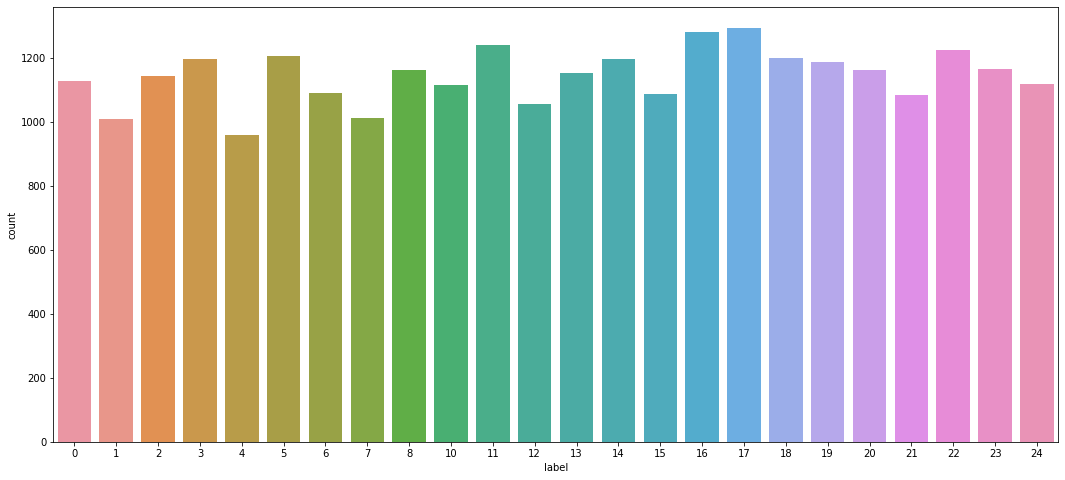

In [83]:
plt.figure(figsize = (18,8))
sns.countplot(x =labels)

En el cuadro de arriba vemos que todas las clases están balanceadas entre mas o menos 1000 y 1300

Y en la celda de abajo quitamos los labels del dataframe de train

In [84]:
df_train = df_train.drop(['label'], axis=1)

Hacemos un array para y le hacemos un reshape de 28 x 28 y volvemos planos los arrays

In [85]:
images = df_train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

In [86]:
images.shape

(27455, 784)

Graficamos un ejemplo de la gráfica número 1

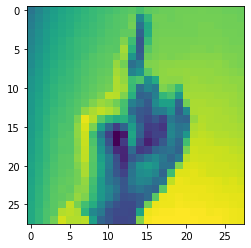

In [87]:
plt.imshow(images[0].reshape(28,28))

Vemos que la clase de la gráfica es 3, que sería la letra d

In [88]:
labels[0]

3

Ahora partimos el model en datos en pixeles y etiquetas x = pixeles y y= etiquetas. Partimos el model en train y val (validación).

Hay una particularidad en este modelo, como tenemos un csv test, entonces lo único que hacemos es colocar el x_test con el csv y separamos las etiquetas para la variable y_test

In [90]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, random_state = 33)
x_test  = df_test.drop(['label'], axis=1)
y_test = df_test['label']

En esta parte nos costó un tiempo entender que el y_train era una serie de pandas y que nosotros necesitabamos un array para enviarlo al modelo

In [91]:
type(y_train)

pandas.core.series.Series

En esta parte normalizamos todos los datasets con pixeles para que nos de valores entre 0 y 1

In [92]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

Aquí volvemos todos los y (labels) a arrays para que se puedan ingresar al modelo

In [93]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

### Aquitectura del Autoenconder

Para el autoencoder, decidimos tener 3 capas de codificación, con una activación sigmoide (ya normalizamos los datos) y que en la mitad tuviera 64 neuronas para sacar 64 caracteristicas de las imagenes

In [94]:
autoencoder = Sequential(name="Autoencoder")

#Capa de Entrada
autoencoder.add(Input(shape=(x_train.shape[1]), name='Input_Layer'))

#Encoder
autoencoder.add(Dense(256, activation='relu', name='Encoder_1'))
autoencoder.add(Dense(128, activation='relu', name='Encoder_2'))
autoencoder.add(Dense(64, activation='relu', name='Encoder_3'))

#Decoder
autoencoder.add(Dense(128, activation='relu', name='Decoder_3'))
autoencoder.add(Dense(256, activation='relu', name='Decoder_2'))
autoencoder.add(Dense(x_train.shape[1], activation='sigmoid', name='Decoder_1'))

En esta parte compilamos nuestro modelo, con un optimizer Adam, (el más utilizado) y decidimos la función de perdida como cross entropia binaria

In [95]:
28,28,autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 256)               200960    
                                                                 
 Encoder_2 (Dense)           (None, 128)               32896     
                                                                 
 Encoder_3 (Dense)           (None, 64)                8256      
                                                                 
 Decoder_3 (Dense)           (None, 128)               8320      
                                                                 
 Decoder_2 (Dense)           (None, 256)               33024     
                                                                 
 Decoder_1 (Dense)           (None, 784)               201488    
                                                                 
Total params: 484,944
Trainable params: 484,944
Non-tra

Graficamos la arquitectura del autoencoder

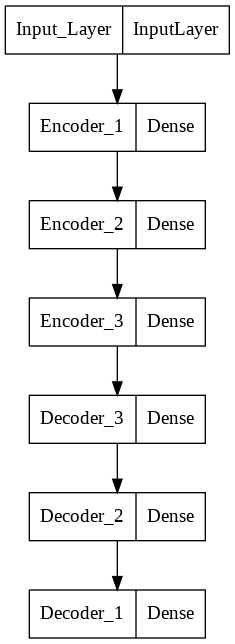

In [96]:
plot_model(autoencoder)

Utilizamos callback, igual que en el taller con patience 4 para que pare de entrenar si no mejora, para que se guarde el modelo de cada epoca y nos guarde los logs

In [97]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs')]

### Modelamiento 

Aquí escogimos 50 epocas y un batch_size de 200, nosotros le podemos dar epocas de 20, pues aquí no mejora mucho aumentandolas.
El batch_size es para que el modelo corra más rápido

In [98]:
autoencoder.fit(x_train,          
                x_train, 
                epochs=50, 
                batch_size=200, 
                callbacks=my_callbacks,
                validation_data=(
                    x_val, 
                    x_val
                    )
                )

Epoch 1/50
110/110 [==============================] - 4s 26ms/step - loss: 0.6386 - val_loss: 0.6241
Epoch 2/50
110/110 [==============================] - 3s 24ms/step - loss: 0.6183 - val_loss: 0.6115
Epoch 3/50
110/110 [==============================] - 3s 24ms/step - loss: 0.6091 - val_loss: 0.6049
Epoch 4/50
110/110 [==============================] - 3s 25ms/step - loss: 0.6050 - val_loss: 0.6036
Epoch 5/50
110/110 [==============================] - 3s 24ms/step - loss: 0.6022 - val_loss: 0.5994
Epoch 6/50
110/110 [==============================] - 3s 30ms/step - loss: 0.6002 - val_loss: 0.5977
Epoch 7/50
110/110 [==============================] - 4s 33ms/step - loss: 0.5986 - val_loss: 0.5967
Epoch 8/50
110/110 [==============================] - 5s 45ms/step - loss: 0.5980 - val_loss: 0.5967
Epoch 9/50
110/110 [==============================] - 4s 40ms/step - loss: 0.5970 - val_loss: 0.5961
Epoch 10/50
110/110 [==============================] - 4s 37ms/step - loss: 0.5962 - val_lo

In [99]:
predicted = autoencoder.predict(x_val[:10], batch_size=1)

predicted[0].shape

(784,)

Se hace una evaluación con los datos de validación

In [100]:
evaluation = autoencoder.evaluate(x_val, x_val)
print('Validation loss : {:.3f}'.format(evaluation))

172/172 [==============================] - 1s 4ms/step - loss: 0.5874
Validation loss : 0.587


Realizamos la comparación de nuestras imágenes originales vs las reconstruidas.

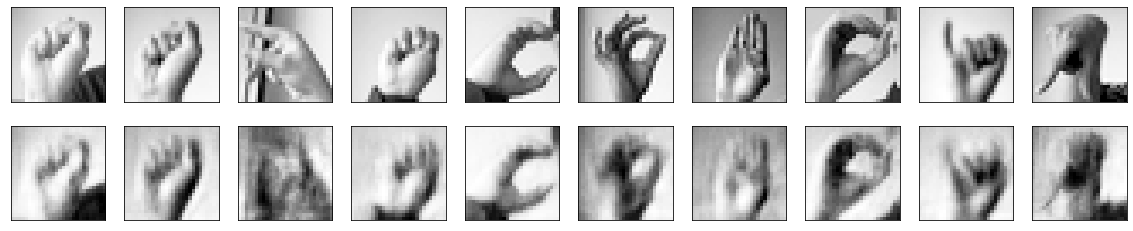

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([x_val[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Transferencia

Hacemos la transferencia de conocimiento para que la entrada del clasificador pase de 784 a 64, que es el número de neuronas de nuestro encoder

In [102]:
encoder = Sequential(name='Encoder')

for layers in autoencoder.layers:
    if "Decoder" in layers.name:
        break
    print(layers.name)
    layers.trainable = False
    encoder.add(layers)

Encoder_1
Encoder_2
Encoder_3


Creamos nuestro nuevo modelo, con una capa de entrada que reciba las fotos y como segundo paso, le agregamos todo el encoder (las 3 capas) que entrenamos en el autoencoder

In [103]:
new_encoder = Sequential(name='Encoder')

new_encoder.add(Input(shape=(x_train.shape[1]), name='Input_Layer'))
new_encoder.add(encoder)# al nuevo modelo se le agrega el viejo ENCODER

new_encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 64)                242112    
                                                                 
Total params: 242,112
Trainable params: 0
Non-trainable params: 242,112
_________________________________________________________________


En esta parte vemos las imagenes como se ven en la extracción de características en la capa de 64 neuronas (encoder3)

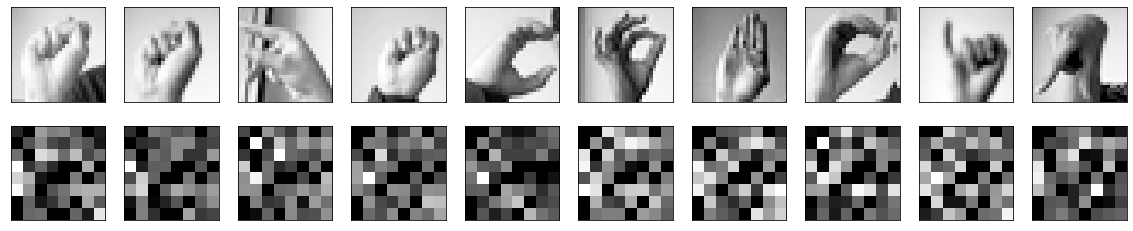

In [104]:
predicted = new_encoder.predict(x_val[:10], batch_size=1)

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=False, sharey=False, figsize=(20,4))

for images, row in zip([x_val[:10].reshape((-1, 28, 28)), predicted.reshape((-1, 8, 8))], axes):
    for img, ax in zip(images, row):
        ax.imshow(img, cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Aquí agregamos el clasificador, le hacemos una capa de entrada, le agregamos el "encoder" y le colocamos las capas del clasificador 3 capas, de 256, 100 y 25 neuronas (última capa)

In [105]:
clf = Sequential(name='Clasificador')

#Capa de Entrada
clf.add(Input(shape=(x_train.shape[1]), name='Input_Layer'))

#Capas Ocultas
clf.add(encoder)
clf.add(Dense(256, activation='relu', name='Capa_Oculta_Clasificador1'))

#Capas Ocultas
clf.add(Dense(100, activation='relu', name='Capa_Oculta_Clasificador2'))

#Capa de Salida
clf.add(Dense(25, activation='softmax', name='Capa_Clasificador'))


clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
clf.summary()

Model: "Clasificador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 64)                242112    
                                                                 
 Capa_Oculta_Clasificador1 (  (None, 256)              16640     
 Dense)                                                          
                                                                 
 Capa_Oculta_Clasificador2 (  (None, 100)              25700     
 Dense)                                                          
                                                                 
 Capa_Clasificador (Dense)   (None, 25)                2525      
                                                                 
Total params: 286,977
Trainable params: 44,865
Non-trainable params: 242,112
_________________________________________________________________


Graficamos el Encoder con el modelo de clasificación

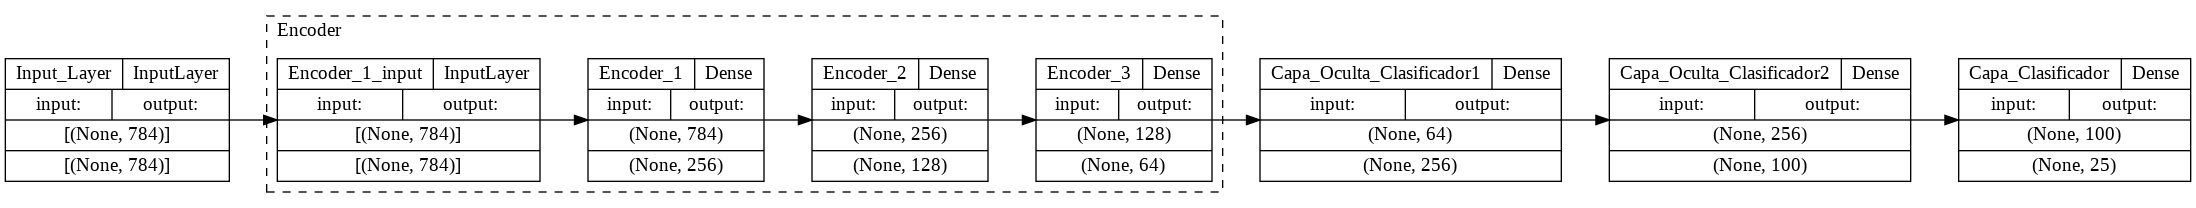

In [106]:
plot_model(clf, show_shapes=True, rankdir='LR', expand_nested=True)

### Entrenamiento de nuevo Modelo

Corremos el entrenamiento para el modelo

In [107]:
clf.fit(x_train,          
        y_train, 
        epochs=50, 
        batch_size=200, 
        callbacks=my_callbacks,
        validation_data=(
            x_val, 
            y_val
            )
        )

Epoch 1/50
110/110 [==============================] - 2s 11ms/step - loss: 2.2214 - accuracy: 0.3809 - val_loss: 1.4435 - val_accuracy: 0.5717
Epoch 2/50
110/110 [==============================] - 1s 9ms/step - loss: 1.2065 - accuracy: 0.6390 - val_loss: 1.0011 - val_accuracy: 0.6973
Epoch 3/50
110/110 [==============================] - 1s 9ms/step - loss: 0.9103 - accuracy: 0.7280 - val_loss: 0.8025 - val_accuracy: 0.7547
Epoch 4/50
110/110 [==============================] - 1s 9ms/step - loss: 0.7133 - accuracy: 0.7881 - val_loss: 0.6631 - val_accuracy: 0.8059
Epoch 5/50
110/110 [==============================] - 1s 9ms/step - loss: 0.5760 - accuracy: 0.8344 - val_loss: 0.5260 - val_accuracy: 0.8532
Epoch 6/50
110/110 [==============================] - 1s 9ms/step - loss: 0.4663 - accuracy: 0.8709 - val_loss: 0.4268 - val_accuracy: 0.8842
Epoch 7/50
110/110 [==============================] - 1s 9ms/step - loss: 0.3772 - accuracy: 0.8997 - val_loss: 0.3461 - val_accuracy: 0.9135
Epoch

### Evaluación

Probamos cómo quedo nuestro modelo, y vemos todos los datos de precision en 1, aquí se ve que nuestro modelo tiene un sobre ajuste muy alto, dado que estamos probandolo con los datos de entrenamiento

In [108]:
y_pred = np.argmax(clf.predict(x_train),axis=1)
print(classification_report(y_true=y_train, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       899
           1       1.00      1.00      1.00       806
           2       1.00      1.00      1.00       915
           3       1.00      1.00      1.00       952
           4       1.00      1.00      1.00       767
           5       1.00      1.00      1.00       946
           6       1.00      1.00      1.00       868
           7       1.00      1.00      1.00       806
           8       1.00      1.00      1.00       926
          10       1.00      1.00      1.00       876
          11       1.00      1.00      1.00      1023
          12       1.00      1.00      1.00       861
          13       1.00      1.00      1.00       930
          14       1.00      1.00      1.00       964
          15       1.00      1.00      1.00       872
          16       1.00      1.00      1.00      1019
          17       1.00      1.00      1.00      1030
          18       1.00    

Ya probando nuestro modelo con los valores de test, se ve que hay 2 categorias con precision= 1 (la B y la Q) estas son señales relativamente fáciles de identificar.

Las que tuvieron más problema en la clasificación fue la 18 (S que se parece muchoa la A), 19(T muy parecida a la G y H) y finalmente la 22 (W que se parece muchoa la F)



In [109]:
y_pred = np.argmax(clf.predict(x_test), axis=1)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       331
           1       1.00      0.95      0.97       432
           2       0.82      0.94      0.88       310
           3       0.88      0.90      0.89       245
           4       0.92      0.97      0.95       498
           5       0.75      0.81      0.78       247
           6       0.91      0.76      0.83       348
           7       0.90      0.97      0.93       436
           8       0.78      0.63      0.70       288
          10       0.66      0.66      0.66       331
          11       0.74      0.98      0.84       209
          12       0.85      0.71      0.78       394
          13       0.64      0.50      0.56       291
          14       0.87      0.58      0.70       246
          15       1.00      1.00      1.00       347
          16       0.66      0.87      0.75       164
          17       0.53      0.72      0.61       144
          18       0.58    

### Conclusiones

Las conclusiones a las que podemos llegar son las siguientes:

1. el dataset tiene varias categorias que se parecen bastante, se cree que con más resolución o con un autoencoder que tengas más variables (ej: autoencoder convolucional) se arreglaría la baja presición del autoencoder

2. La inicialización de los pesos podría ayudar a mejorar el modelo,

3. Utilizando el encoder con el clasificador, mejora la precisión del modelo 

## **Autoenconder denoising**

### Preparación Datos

Sobre escribimos las variables para no tener verisones anteriores. 

In [110]:
df_train = pd.read_csv('sign_mnist_train.csv')
df_test = pd.read_csv('sign_mnist_test.csv')
df_train.shape

(27455, 785)

In [111]:
df_train = df_train.sample(frac = 0.1)
df_train.shape

(2746, 785)

In [112]:
labels = df_train['label']


Miramos cuantas clases tenemos

In [113]:
unique_value = np.array(labels)
np.unique(unique_value)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

Y ahora graficamos cada clase para saber si el dataset está balanceado, en esta parte vemos que el dataset no es balanceado porque la función .sample toma el primer 10% del dataset, entonces hay clases que tiene pocas muestras.

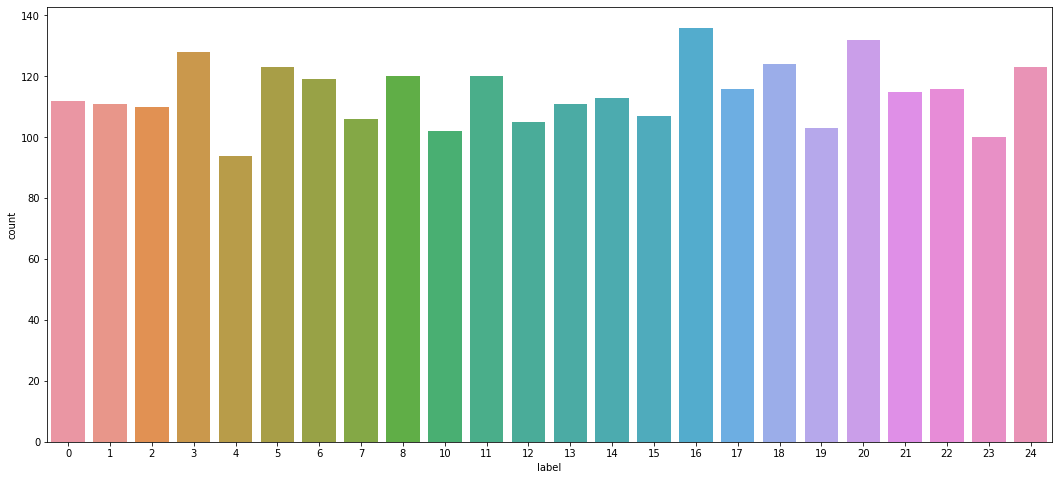

In [114]:
plt.figure(figsize = (18,8))
sns.countplot(x =labels)

En el cuadro de arriba vemos que todas las clases no están balanceadas, hay valores de 90 valores y lotros altos de 140

Y en la celda de abajo quitamos los labels del dataframe de train

In [115]:
df_train = df_train.drop(['label'], axis=1)

Hacemos un array para y le hacemos un reshape de 28 x 28 y volvemos planos los arrays

In [116]:
images = df_train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

In [117]:
images.shape

(2746, 784)

Graficamos un ejemplo de la gráfica número 1

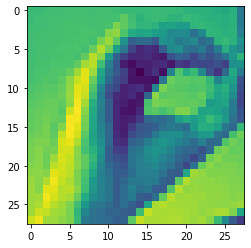

In [118]:
plt.imshow(images[0].reshape(28,28))

Vemos que la clase de la gráfica es 3, que sería la letra d

Ahora partimos el model en datos en pixeles y etiquetas x = pixeles y y= etiquetas. Partimos el model en train y val (validación).

Hay una particularidad en este modelo, como tenemos un csv test, entonces lo único que hacemos es colocar el x_test con el csv y separamos las etiquetas para la variable y_test.

También colocamos un random_state de 33 para poder reproducir los resultados

In [119]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, random_state = 33)
x_test  = df_test.drop(['label'], axis=1)
y_test = df_test['label']

In [120]:
x_test = x_test.to_numpy()

En esta parte normalizamos todos los datasets con pixeles para que nos de valores entre 0 y 1

In [121]:
x_train = x_train.astype('float32') / 255
x_val = x_val / 255
x_test = x_test.astype('float32') / 255

Aquí volvemos todos los y (labels) a arrays para que se puedan ingresar al modelo

In [122]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

### Ruido Gausiano


Agregamos el ruido gaussiano a los datos de entrenamiento, viendo el ruido en los datos, decidimos colocar un factor de ruido de 0.06, pues con valores mayores casi no se entiende la foto.

Ya que el test es el dataset a comparar al final del ejercicio, no le agregamos ruido

In [123]:
noise_factor = 0.06
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
#x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
#x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


Arreglamos las imagenes 1 para poder graficar las imagenes con ruido

In [124]:
images1 = x_train_noisy
images1 = np.array([np.reshape(i, (28, 28)) for i in images1])
images1 = np.array([i.flatten() for i in images1])

Graficamos la imagen 1 del dataset con ruido (imagen1) y le damos su etiqueta

15

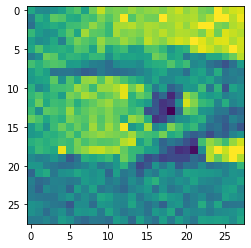

In [125]:
plt.imshow(images1[1].reshape(28,28))
y_train[1]

### Autoencoder

Para el autoencoder, decidimos tener 3 capas de codificación, con una activación sigmoide (ya normalizamos los datos) y que en la mitad tuviera 64 neuronas para sacar 64 caracteristicas de las imagenes

Pregunta!!! Tenemos una capa comentada, ¿el ruido gaussiano también se puede generar de esta manera? 

In [126]:
autoencoder = Sequential(name="Autoencoder")

#Capa de Entrada
autoencoder.add(Input(shape=(x_train.shape[1]), name='Input_Layer'))

#Encoder
#autoencoder.add(tf.keras.layers.GaussianNoise(0.3), name= 'GaussianNoise')
autoencoder.add(Dense(256, activation='relu', name='Encoder_1'))
autoencoder.add(Dense(128, activation='relu', name='Encoder_2'))
autoencoder.add(Dense(64, activation='relu', name='Encoder_3'))

#Decoder
autoencoder.add(Dense(128, activation='relu', name='Decoder_3'))
autoencoder.add(Dense(256, activation='relu', name='Decoder_2'))
autoencoder.add(Dense(x_train.shape[1], activation='sigmoid', name='Decoder_1'))

En esta parte compilamos nuestro modelo, con un optimizer Adam, (el más utilizado) y decidimos la función de perdida como cross entropia binaria

In [127]:
28,28,autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 256)               200960    
                                                                 
 Encoder_2 (Dense)           (None, 128)               32896     
                                                                 
 Encoder_3 (Dense)           (None, 64)                8256      
                                                                 
 Decoder_3 (Dense)           (None, 128)               8320      
                                                                 
 Decoder_2 (Dense)           (None, 256)               33024     
                                                                 
 Decoder_1 (Dense)           (None, 784)               201488    
                                                                 
Total params: 484,944
Trainable params: 484,944
Non-tra

#### Arquitectura

Graficamos la arquitectura del autoencoder

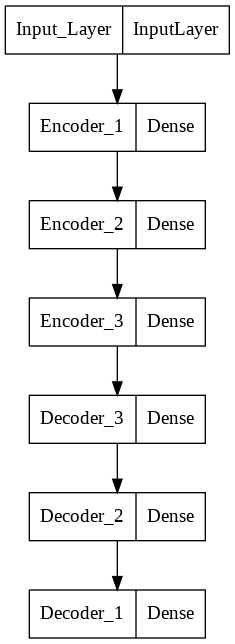

In [128]:
plot_model(autoencoder)

### Callback y entrenamiento

Utilizamos callback, igual que en el taller con patience 4 para que pare de entrenar si no mejora, para que se guarde el modelo de cada epoca y nos guarde los logs

In [129]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs')]

Aquí escogimos 50 epocas y un batch_size de 200, nosotros le podemos dar epocas de 20, pues aquí no mejora mucho aumentandolas.
El batch_size es para que el modelo corra más rápido.

In [130]:
autoencoder.fit(x_train_noisy,          
                x_train_noisy, 
                epochs=50, 
                batch_size=200, 
                callbacks=my_callbacks,
                validation_data=(
                    x_val, 
                    x_val
                    )
                )

Epoch 1/50
11/11 [==============================] - 1s 45ms/step - loss: 0.6699 - val_loss: 0.6503
Epoch 2/50
11/11 [==============================] - 0s 30ms/step - loss: 0.6473 - val_loss: 0.6464
Epoch 3/50
11/11 [==============================] - 0s 31ms/step - loss: 0.6446 - val_loss: 0.6442
Epoch 4/50
11/11 [==============================] - 0s 31ms/step - loss: 0.6435 - val_loss: 0.6427
Epoch 5/50
11/11 [==============================] - 0s 30ms/step - loss: 0.6422 - val_loss: 0.6410
Epoch 6/50
11/11 [==============================] - 0s 39ms/step - loss: 0.6400 - val_loss: 0.6378
Epoch 7/50
11/11 [==============================] - 0s 31ms/step - loss: 0.6355 - val_loss: 0.6326
Epoch 8/50
11/11 [==============================] - 0s 30ms/step - loss: 0.6305 - val_loss: 0.6267
Epoch 9/50
11/11 [==============================] - 0s 29ms/step - loss: 0.6266 - val_loss: 0.6247
Epoch 10/50
11/11 [==============================] - 0s 34ms/step - loss: 0.6237 - val_loss: 0.6217
Epoch 11/

### Evaluación

Predicción de nuestro modelo

In [131]:
predicted = autoencoder.predict(x_val[:10], batch_size=1)

predicted[0].shape

(784,)

Se hace una evaluación con los datos de validación y se 

In [132]:
evaluation = autoencoder.evaluate(x_val, x_val)
print('Validation loss : {:.3f}'.format(evaluation))

18/18 [==============================] - 0s 3ms/step - loss: 0.5974
Validation loss : 0.597


Realizamos la comparación de nuestras imágenes originales con ruido vs las reconstruidas.

el images1 (las originales + ruido) comparadas con las predicciones

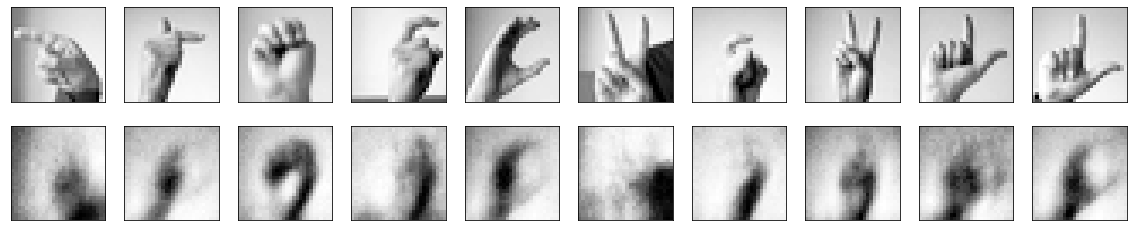

In [133]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images1, row in zip([x_val[:10], predicted], axes):
    for img, ax in zip(images1, row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Transferencia de K

Hacemos la transferencia de conocimiento para que la entrada del clasificador pase de 784 a 64, que es el número de neuronas de nuestro encoder

In [134]:
encoder = Sequential(name='Encoder')

for layers in autoencoder.layers:
    if "Decoder" in layers.name:
        break
    print(layers.name)
    layers.trainable = False
    encoder.add(layers)

Encoder_1
Encoder_2
Encoder_3


Creamos nuestro nuevo modelo, con una capa de entrada que reciba las fotos y como segundo paso, le agregamos todo el encoder (las 3 capas) que entrenamos en el autoencoder

In [135]:
new_encoder = Sequential(name='Encoder')

new_encoder.add(Input(shape=(x_train.shape[1]), name='Input_Layer'))
new_encoder.add(encoder)# al nuevo modelo se le agrega el viejo ENCODER

new_encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 64)                242112    
                                                                 
Total params: 242,112
Trainable params: 0
Non-trainable params: 242,112
_________________________________________________________________


En esta parte vemos las imagenes como se ven en la extracción de características en la capa de 64 neuronas (encoder3)

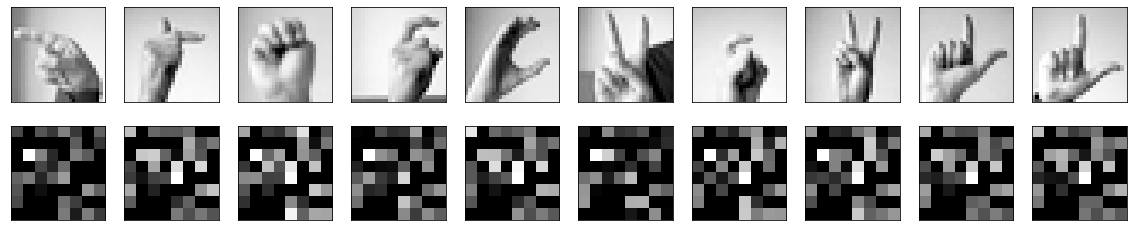

In [136]:
predicted = new_encoder.predict(x_val[:10], batch_size=1)

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=False, sharey=False, figsize=(20,4))

for images, row in zip([x_val[:10].reshape((-1, 28, 28)), predicted.reshape((-1, 8, 8))], axes):
    for img, ax in zip(images, row):
        ax.imshow(img, cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Nuevo entrenamiento completo

Aquí agregamos el clasificador, le hacemos una capa de entrada, le agregamos el "encoder" y le colocamos las capas del clasificador 3 capas, de 256, 100 y 25 neuronas (última capa)

In [137]:
clf = Sequential(name='Clasificador')

#Capa de Entrada
clf.add(Input(shape=(x_train.shape[1]), name='Input_Layer'))

#Capas Ocultas
clf.add(encoder)
clf.add(Dense(256, activation='relu', name='Capa_Oculta_Clasificador1'))

#Capas Ocultas
clf.add(Dense(100, activation='relu', name='Capa_Oculta_Clasificador2'))

#Capa de Salida
clf.add(Dense(25, activation='softmax', name='Capa_Clasificador'))


clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
clf.summary()

Model: "Clasificador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 64)                242112    
                                                                 
 Capa_Oculta_Clasificador1 (  (None, 256)              16640     
 Dense)                                                          
                                                                 
 Capa_Oculta_Clasificador2 (  (None, 100)              25700     
 Dense)                                                          
                                                                 
 Capa_Clasificador (Dense)   (None, 25)                2525      
                                                                 
Total params: 286,977
Trainable params: 44,865
Non-trainable params: 242,112
_________________________________________________________________


Graficamos el Encoder con el modelo de clasificación

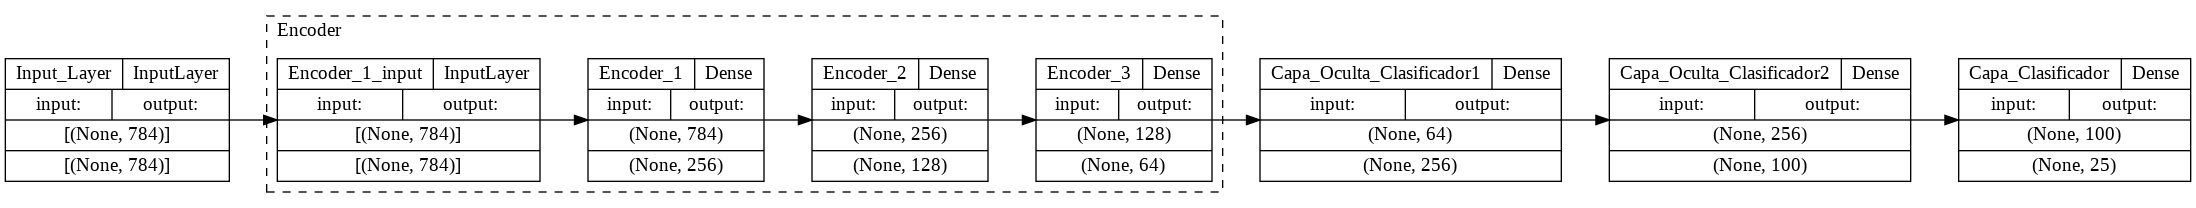

In [138]:
plot_model(clf, show_shapes=True, rankdir='LR', expand_nested=True)

Corremos el entrenamiento para el modelo, en esta parte le agregamos el las etiquetas, pues es el clasificador (y_train y y_val)

In [139]:
clf.fit(x_train_noisy,          
        y_train, 
        epochs=50, 
        batch_size=200, 
        callbacks=my_callbacks,
        validation_data=(
            x_val, 
            y_val
            )
        )

Epoch 1/50
11/11 [==============================] - 1s 30ms/step - loss: 3.1812 - accuracy: 0.0842 - val_loss: 3.0387 - val_accuracy: 0.1473
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 2.8940 - accuracy: 0.1995 - val_loss: 2.8166 - val_accuracy: 0.1818
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 2.6588 - accuracy: 0.2386 - val_loss: 2.6350 - val_accuracy: 0.2145
Epoch 4/50
11/11 [==============================] - 0s 13ms/step - loss: 2.4471 - accuracy: 0.2814 - val_loss: 2.4552 - val_accuracy: 0.2709
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 2.2697 - accuracy: 0.3210 - val_loss: 2.3136 - val_accuracy: 0.2891
Epoch 6/50
11/11 [==============================] - 0s 14ms/step - loss: 2.1390 - accuracy: 0.3402 - val_loss: 2.2212 - val_accuracy: 0.2855
Epoch 7/50
11/11 [==============================] - 0s 14ms/step - loss: 2.0282 - accuracy: 0.3638 - val_loss: 2.1241 - val_accuracy: 0.3545
Epoch 8/50
11

### Evaluación

Probamos cómo quedo nuestro modelo, y vemos todos los datos de precisiones bajas, esto se debe a el dataset pequeño y con clases que no están balanceadas

In [140]:
y_pred = np.argmax(clf.predict(x_train),axis=1)
print(classification_report(y_true=y_train, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76        89
           1       0.86      0.75      0.80        84
           2       0.84      0.93      0.88        89
           3       0.63      0.84      0.72       102
           4       0.80      0.69      0.74        75
           5       0.69      0.80      0.74        96
           6       0.83      0.76      0.79        95
           7       0.96      0.79      0.87        87
           8       0.76      0.55      0.64        96
          10       0.77      0.76      0.76        82
          11       0.61      0.83      0.70        93
          12       0.63      0.51      0.56        86
          13       0.71      0.57      0.63        90
          14       0.95      0.76      0.84        98
          15       0.92      0.99      0.95        83
          16       1.00      0.93      0.96       113
          17       0.46      0.62      0.53       101
          18       0.57    

Ya probando nuestro modelo con los valores de test, se ve que hay 2 categorias con precision= 1 (la B y la Q) estas son señales relativamente fáciles de identificar.

Las que tuvieron más problema en la clasificación fue la 18 (S que se parece muchoa la A), 19(T muy parecida a la G y H) y finalmente la 22 (W que se parece muchoa la F)

Incluso hay valores de presicion 0 (o valores cercanos) en las categorias difíciles de diferenciar


In [141]:
y_pred = np.argmax(clf.predict(x_test), axis=1)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.68      0.88      0.76       331
           1       0.75      0.65      0.70       432
           2       0.58      0.88      0.70       310
           3       0.39      0.69      0.50       245
           4       0.83      0.55      0.66       498
           5       0.47      0.52      0.50       247
           6       0.63      0.57      0.60       348
           7       0.95      0.72      0.82       436
           8       0.38      0.38      0.38       288
          10       0.59      0.48      0.53       331
          11       0.48      0.60      0.54       209
          12       0.56      0.36      0.44       394
          13       0.47      0.52      0.49       291
          14       0.54      0.25      0.34       246
          15       0.86      0.96      0.91       347
          16       0.74      0.84      0.79       164
          17       0.09      0.25      0.13       144
          18       0.12    

### Conclusiones

Las conclusiones a las que podemos llegar son las siguientes:

1. el dataset tiene varias categorias que se parecen bastante, y con el agravante de las categorias no balanceadas y la cantidad de muestras (10% de los datos originales) el modelo nos da una presición bastante baja.
Con un dataset no balanceado, la presición y el recall pierden algo de veracidad
2. Como tenemos imagenes de 28 x 28, con un ruido gaussiano de 0.3 (sugerido en clase) las imagenes casi no se reconocían, debimos bajar el ruido hasta 0.06 para poder distingir las imagenes. Esto se debe a que la imagen es muy pequeña para la cantidad de ruido que le queríamos introducir (cada pixel se hace muy relevante)
